In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GDRIVE

In [ ]:
#import liobraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 300

In [ ]:
#load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        '/content/drive/MyDrive/dataset_Leafrice_diseases_images',
        shuffle=True,
        image_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE
)

Found 3355 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names

In [ ]:
len(dataset)

105

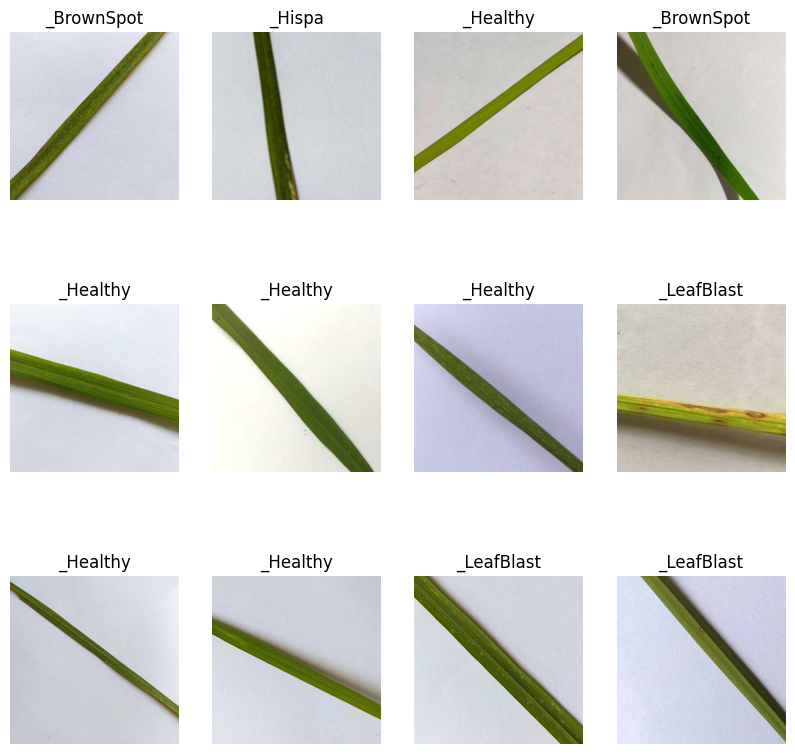

In [ ]:
#exploring a single batch
plt.figure(figsize=(10,10)) #increase image area to 10x10
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])#display title
        plt.axis("off")
        #print(image_batch[0].shape)#exploration
        #print(label_batch.numpy())#covert to numpy

# split dataset into train and test
### 80% ==> training
### 20% ==> 10% validation, 10% test

In [ ]:

#split dataset in function
def get_dataset_partition_tf (ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds) #dataset size
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size) #train size converted to intger to avoid float
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [ ]:
len(train_ds)

84

In [ ]:
len(val_ds)

10

In [ ]:
len(test_ds)

11

In [ ]:
#cache will read image from disk and keep image in memeory for next iteration.
#prefetch and cache to optimize our input pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #buffer_size=tf.data.AUTOTUNE is to allow tf determine the batch size
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#resize and rescale
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE), #resize new inputs
    layers.experimental.preprocessing.Rescaling(1.0/255) #scale down RGB
])

In [ ]:
#data_augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape), #google Conv2D for all arguement. 32=no. of layers
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    #flatten into an array of neurons
    layers.Flatten(),
    layers.Dense(64, activation='relu'), #dense layer of 64 neurons
    layers.Dense(n_classes, activation='softmax'), #softmax normalizes the prob of classes.
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'] #track training process
)

In [ ]:
#good to record the history of every epochs in params
history = model.fit(
    train_ds,
    epochs=15,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/15
84/84 [==============================] - 5s 64ms/step - loss: 1.1470 - accuracy: 0.5147 - val_loss: 1.0983 - val_accuracy: 0.5250
Epoch 2/15
84/84 [==============================] - 5s 59ms/step - loss: 1.1475 - accuracy: 0.5151 - val_loss: 1.0999 - val_accuracy: 0.5188
Epoch 3/15
84/84 [==============================] - 5s 61ms/step - loss: 1.1123 - accuracy: 0.5229 - val_loss: 1.0699 - val_accuracy: 0.5219
Epoch 4/15
84/84 [==============================] - 5s 62ms/step - loss: 1.1190 - accuracy: 0.5207 - val_loss: 1.0857 - val_accuracy: 0.5219
Epoch 5/15
84/84 [==============================] - 5s 63ms/step - loss: 1.1069 - accuracy: 0.5319 - val_loss: 1.0750 - val_accuracy: 0.5219
Epoch 6/15
84/84 [==============================] - 5s 62ms/step - loss: 1.0880 - accuracy: 0.5337 - val_loss: 1.0586 - val_accuracy: 0.5000
Epoch 7/15
84/84 [==============================] - 5s 59ms/step - loss: 1.1325 - accuracy: 0.5218 - val_loss: 1.0879 - val_accuracy: 0.5188
Epoch 8/15
84

In [ ]:
#test model with test_ds
scores = model.evaluate(test_ds)

11/11 [==============================] - 0s 26ms/step - loss: 1.0289 - accuracy: 0.6136


In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 84}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.5147223472595215,
 0.515095055103302,
 0.5229220986366272,
 0.5206857919692993,
 0.5318673253059387,
 0.5337309241294861,
 0.5218039751052856,
 0.5370853543281555,
 0.5329854488372803,
 0.536712646484375,
 0.5359671711921692,
 0.5512486100196838,
 0.5560939311981201,
 0.57920241355896,
 0.6034290194511414]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

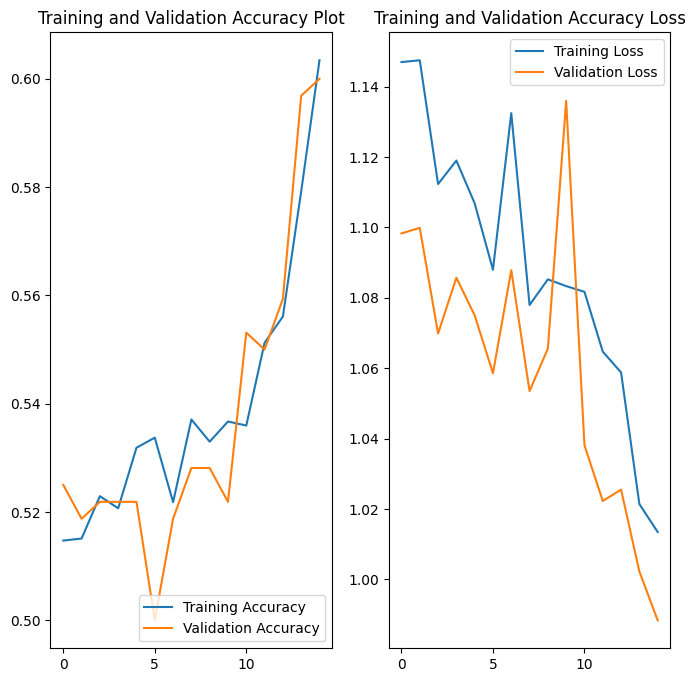

In [ ]:
#plotting training and validation accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(15), acc, label = 'Training Accuracy')
plt.plot(range(15), val_acc, label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Plot')

plt.subplot(1,2,2)
plt.plot(range(15), loss, label = 'Training Loss')
plt.plot(range(15), val_loss, label ='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy Loss')
plt.show()

In [ ]:
history.history['val_accuracy']

[0.5249999761581421,
 0.518750011920929,
 0.5218750238418579,
 0.5218750238418579,
 0.5218750238418579,
 0.5,
 0.518750011920929,
 0.528124988079071,
 0.528124988079071,
 0.5218750238418579,
 0.5531250238418579,
 0.550000011920929,
 0.559374988079071,
 0.596875011920929,
 0.6000000238418579]

In [ ]:
np.argmax([0.04980154,0.5683826,0.2425103,0.13930552])

1

first image to predict
actual label: _Hispa
1/1 [==============================] - 0s 237ms/step
prediction:  _Healthy


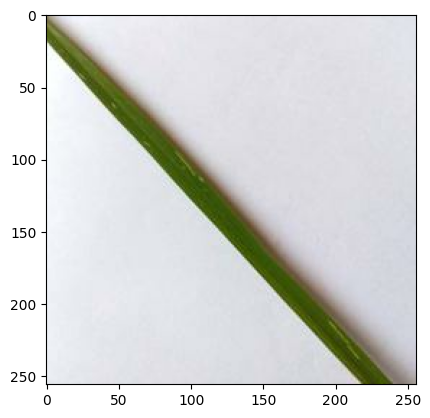

In [ ]:
#make a prediction - 1 batch - test_ds

for images_batch, labels_batch in test_ds.take(1):
    #print(images_batch[0].numpy().astype('uint8'))
    #plt.imshow(images_batch[0].numpy().astype('uint8'))
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    #model is ready so call predict function
    batch_prediction = model.predict(images_batch)
    print("prediction: ", class_names[np.argmax(batch_prediction[0])])

In [ ]:
#prediction class vs confidence
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


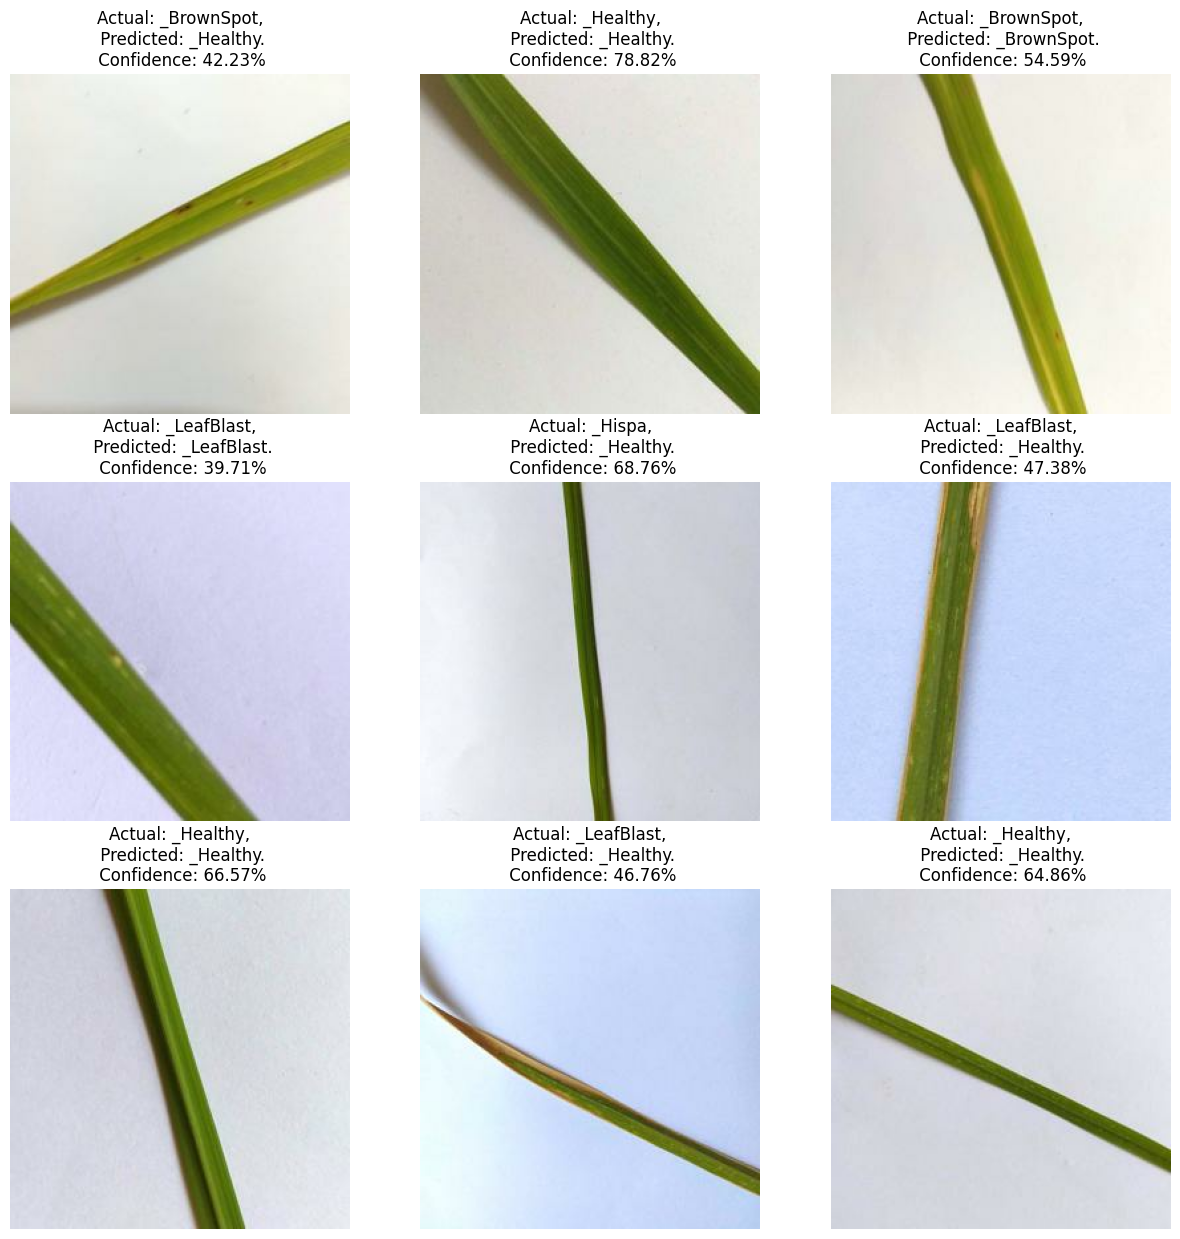

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%") #using python format string

        plt.axis("off")

In [ ]:
# model_version = 1
model.save(f"rice_models.h5")